# VECTOR AUTOREGRESSION (VAR) MODELS

- Vector Autoregression (VAR) is a multivariate forecasting algorithm that is used when two or more time series influence each other.
That is, the relationship between the time series involved is bi-directional.

- VAR models are used when the time series have a cause-and-effect relationship, i.e., when the value of one time series depends on the values of a set of previous time series values.

- VAR models are also known as multivariate time series models.

- VAR models are generalizations of univariate autoregressive models (AR models) as they allow us to forecast a variable using a linear combination of past values of all the variables.

- VAR models are fitted to multiple time series simultaneously.

- VAR models are used for forecasting, structural analysis, impulse response analysis, and forecast error variance decomposition (FEVD).

- VAR models are used in many fields such as economics, finance, medicine, etc.

- VAR models are used in macroeconomics to capture the interdependencies between economic variables such as inflation, interest rates, employment, etc.

- VAR models are used in finance to capture the interdependencies between stock prices, interest rates, exchange rates, etc.

- VAR models are used in medicine to capture the interdependencies between the vital signs of a patient such as blood pressure, heart rate, body temperature, etc.

- VAR models are used in meteorology to capture the interdependencies between weather variables such as temperature, humidity, precipitation, etc.

- VAR models are used in many other fields such as agriculture, engineering, etc.



- Vector autoregressive models are used when you want to predict multiple time series using one model. With them we have to check for stationarity. Convert the data to a stationary form. Then I'll show you how to invert stationarity back to the original form.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller


# Augmented Dickey-Fuller

In [20]:
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

- Vector autoregressive models are used when you want to predict multiple time series using one model. This differs from ARIMA in that we will have to check for stationarity on our own. We will make the data stationary and then invert it back to its original form.

- We'll use AIC to measure our model. As the model increases in complexity it will get more accurate up to a point where AIC will punish that complexity.

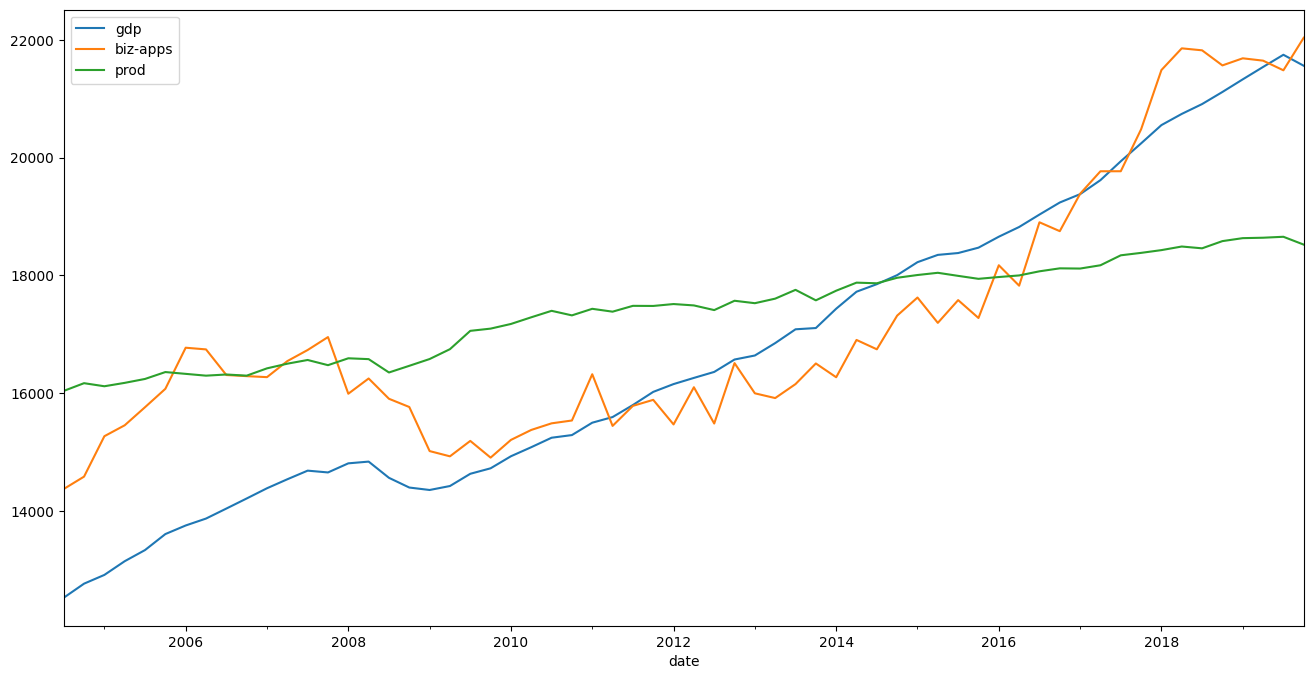

In [21]:
from statsmodels.tsa.api import VAR

gdp_df = pd.read_csv('gdp-data.csv', 
                     index_col='date', parse_dates=True)
gdp_df = gdp_df[gdp_df.index<'2020-03-31']
gdp_df = gdp_df.dropna()
gdp_df = gdp_df.asfreq('Q') # Change frequency to quarterly

ax = gdp_df['gdp'].plot(legend=True, figsize=(16,8))

# Does new business creation influence GDP?
gdp_df['biz-apps'] = gdp_df['biz-apps'] * .025
gdp_df['biz-apps'].plot(legend=True)

# Does productivity influence GDP?
gdp_df['prod'] = gdp_df['prod'] * 180
gdp_df['prod'].plot(legend=True)

plt.show()

# Make Data Stationary

Dickey-Fuller Test
Test Statistic                 -4.231840
p-value                         0.000582
#Lags Used                      0.000000
Number of Observations Used    60.000000
dtype: float64
Dickey-Fuller Test
Test Statistic                 -4.847785
p-value                         0.000044
#Lags Used                      1.000000
Number of Observations Used    59.000000
dtype: float64


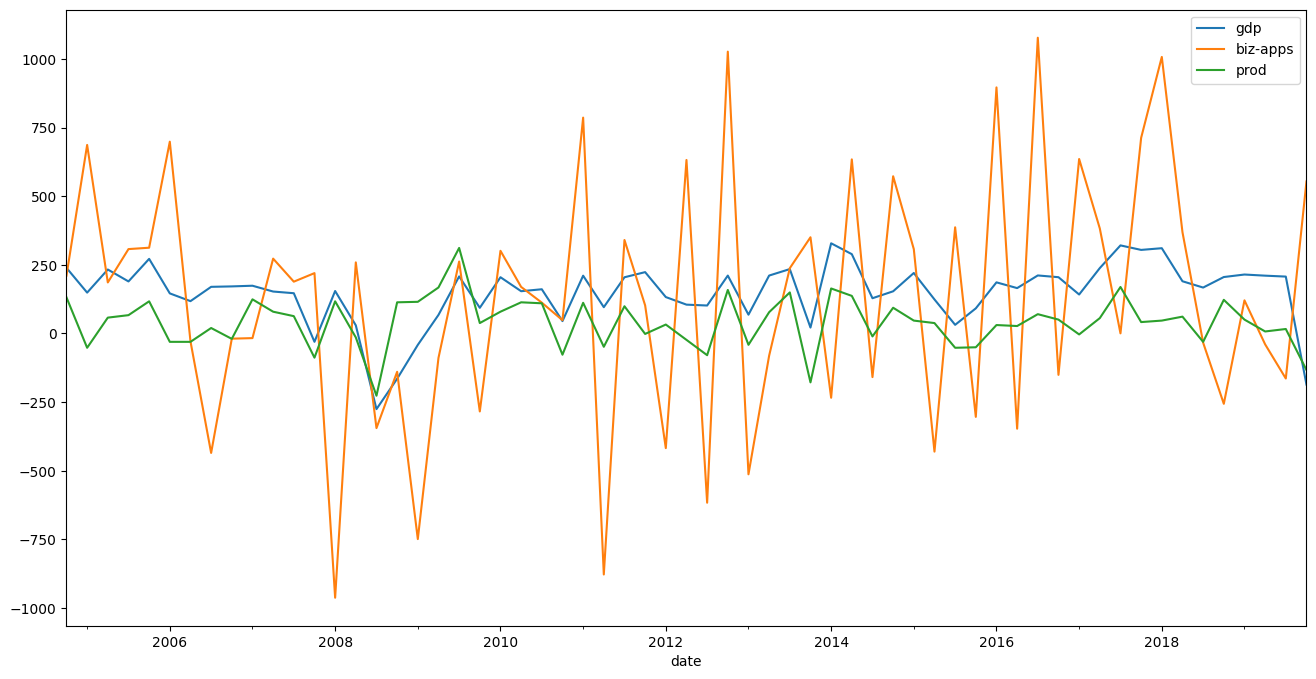

In [22]:
# Difference the data
gdp_diff_df = gdp_df.diff()
gdp_diff_df

# Delete NaNs
gdp_diff_df = gdp_diff_df.dropna()

ax = gdp_diff_df['gdp'].plot(legend=True, figsize=(16,8))
gdp_diff_df['biz-apps'].plot(legend=True)
gdp_diff_df['prod'].plot(legend=True)

# Check for stationarity (If not run diff on both again)
adf_test(gdp_diff_df['gdp'])
adf_test(gdp_diff_df['biz-apps'])

# Train and Test


In [23]:
gdp_diff_df.size # 183

train_df = gdp_diff_df[:146]
test_df = gdp_diff_df[146:]

# auto_arima doesn't work for vector autoregressions so we must find p by checking
# for the lowest value of AIC
mod = VAR(train_df)

# Try 7 lags
for p in range(1,8):
    res = mod.fit(p)
    print(f'Order : {p}, AIC : {res.aic}')
    
res = mod.fit(1)
# We see results for all pieces of data. As we can see productivity matches up
# well with GDP
res.summary()

Order : 1, AIC : 29.430765695054923
Order : 2, AIC : 29.506892530237966
Order : 3, AIC : 29.574206262492687
Order : 4, AIC : 29.774732348897363
Order : 5, AIC : 29.824515444937557
Order : 6, AIC : 29.93452666608275
Order : 7, AIC : 29.995411157086053


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, May, 2023
Time:                     11:33:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    29.8496
Nobs:                     60.0000    HQIC:                   29.5946
Log likelihood:          -1126.33    FPE:                6.05170e+12
AIC:                      29.4308    Det(Omega_mle):     4.98644e+12
--------------------------------------------------------------------
Results for equation gdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              65.707462        24.205971            2.715           0.007
L1.gdp              0.634429         0.158564            4.001           0.000
L1.biz-apps        -0.010715         0.031128           -0.344        

# Plotting


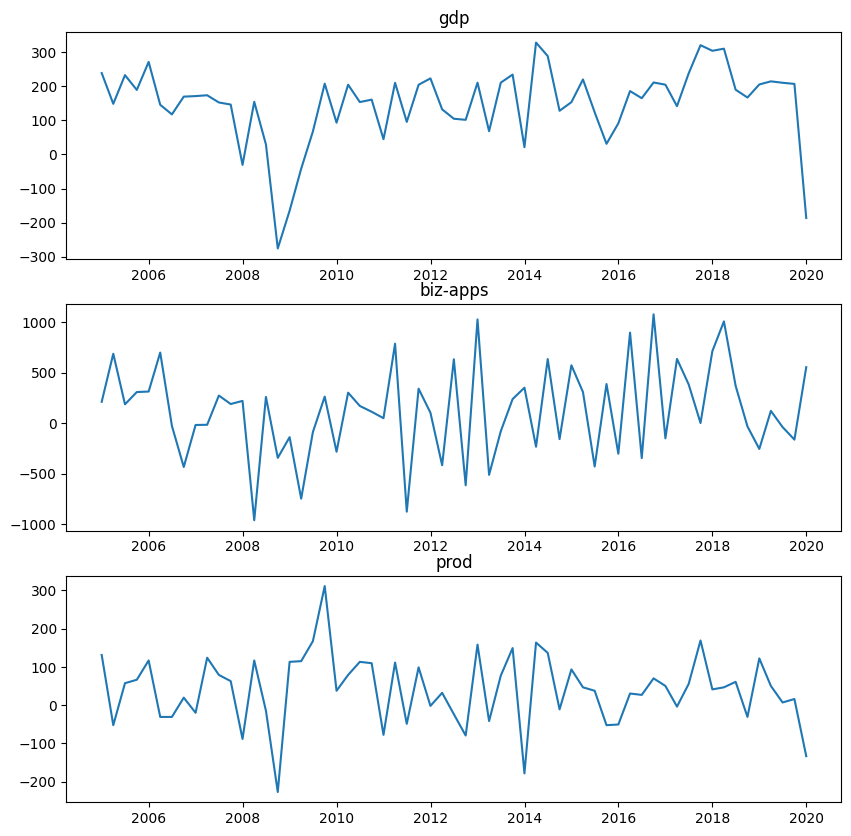

In [24]:
res.plot()
plt.show()

# FORECASTING


,gdp,biz-apps,prod
date,,,
2004-12-31,238.912,210.650,131.4
2005-03-31,148.685,686.525,-52.2
2005-06-30,232.851,185.750,57.6
2005-09-30,189.443,307.200,66.6
2005-12-31,271.617,312.225,117.0
...,...,...,...
2018-12-31,205.456,-256.300,122.4
2019-03-31,214.568,120.575,50.4
2019-06-30,210.448,-39.700,7.2


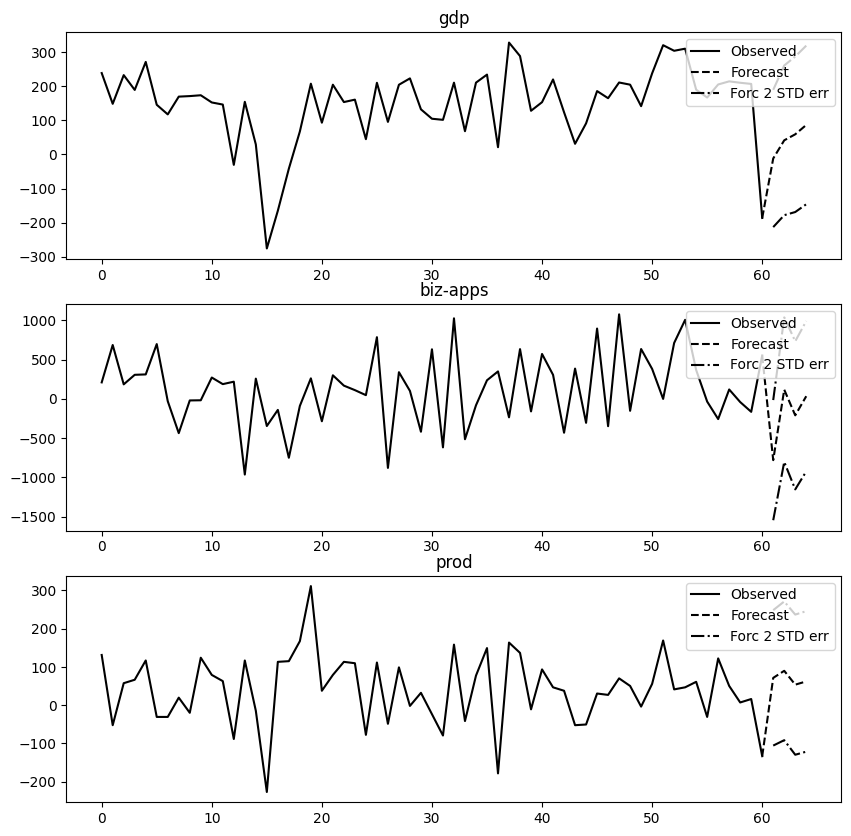

In [25]:
# When forecasting we define how many steps ahead to forecast. We also pass an array
# with p, the lag order, k, the number of time series terms (gdp & prod). We have to
# pass the 4 passed values before the test set begins.

# Produce the forecast
# Values returns a Numpy array
forecast_res = res.forecast(gdp_diff_df.values[-1:], 4)

# Plot the forecast
res.plot_forecast(4)

gdp_diff_df

# Setup Dataframe with Forecast Data

In [26]:
indx = pd.date_range('6/30/2020', periods=4, freq='Q-DEC')
# Provide frequency data, index and columns
forecast_df = pd.DataFrame(forecast_res, index=indx,
                          columns=['f-gdp', 'f-biz-apps', 'f-prod'])
forecast_df

,f-gdp,f-biz-apps,f-prod
2020-06-30,-11.649082,-779.058239,71.495463
2020-09-30,41.576289,118.196268,89.948953
2020-12-31,59.255006,-208.639970,53.757967
2021-03-31,86.672287,34.852294,62.252630


# Undoing a Difference


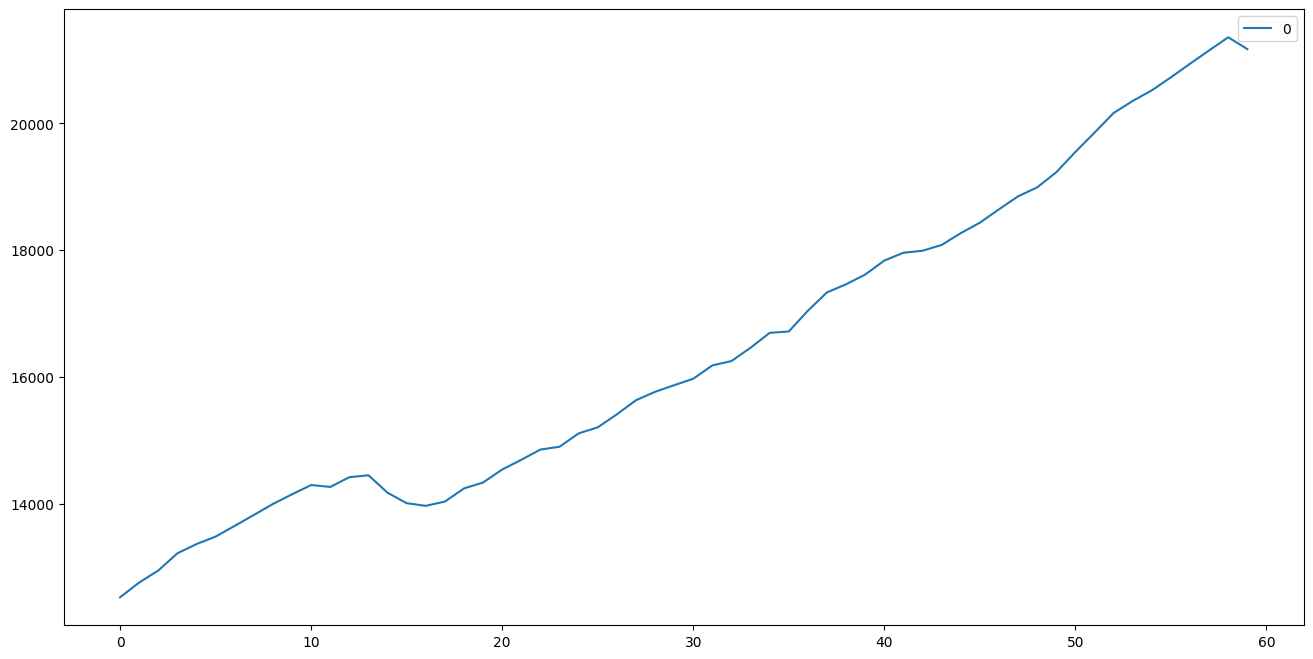

In [28]:
# Generate random data and difference it
ex_df = pd.DataFrame({'A': np.random.randint(0, 10, 5)})
ex_df['B'] = ex_df['A'].diff()
ex_df

x, x_diff = ex_df['A'].iloc[0], ex_df['B'].iloc[1:]
# r_ stack slices along their 1st axis
ex_df['C'] = np.r_[x, x_diff].cumsum().astype(float)
ex_df

# Get all of original GDP column and the differenced column skipping
# the NaNs at the front
x, x_diff = gdp_df['gdp'].iloc[0], gdp_diff_df['gdp'].iloc[2:]
# Cumulatively sum the values and stack the slices to eliminate
# the difference
n_gdp_df = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))

pd.concat([n_gdp_df.squeeze(), (forecast_df['f-gdp'].cumsum())])
n_gdp_df.plot(figsize=(16,8))
plt.show()
# You can do the same with biz-apps and prod for homework